# WGAN训练
## 引入

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt

from models import WGAN
from utils import load_cifar

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

## 环境参数

In [2]:
# run params
SECTION = "gan"
RUN_ID = "0002"
DATA_NAME = "horses"
RUN_FOLDER = "run/{}/".format(SECTION)
RUN_FOLDER += "_".join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.makedirs(os.path.join(RUN_FOLDER, "viz"))
    os.makedirs(os.path.join(RUN_FOLDER, "images"))
    os.makedirs(os.path.join(RUN_FOLDER, "weights"))

MODE = "build" # "load"

## 加载数据

In [3]:
if DATA_NAME == "cars":
    label = 1
elif DATA_NAME == "horses":
    label = 7
(x_train, y_train) = load_cifar(label, 10)

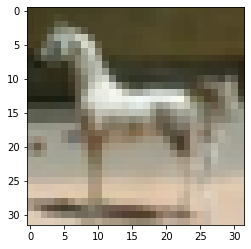

In [4]:
plt.imshow((x_train[150, :, :, :] + 1) / 2)

## 神经网络结构

In [5]:
wgan = WGAN(
    input_dim=(32, 32, 3),
    critic_conv_filters=[32, 64, 128, 128],
    critic_conv_kernel_size=[5, 5, 5, 5],
    critic_conv_strides=[2, 2, 2, 1],
    critic_batch_norm_momentum=None,
    critic_activation="leaky_relu",
    critic_dropout_rate=None,
    critic_learning_rate=0.00005,
    generator_initial_dense_layer_size=(4, 4, 128),
    generator_upsample=[2, 2, 2, 1],
    generator_conv_filters=[128, 64, 32, 3],
    generator_conv_kernel_size=[5, 5, 5, 5],
    generator_conv_strides=[1, 1, 1, 1],
    generator_batch_norm_momentum=0.8,
    generator_activation="leaky_relu",
    generator_dropout_rate=None,
    generator_learning_rate=0.00005,
    optimizer="rmsprop",
    z_dim=100
)

if MODE == "build":
    wgan.save(RUN_FOLDER)
else:
    wgan.load_weights(os.path.join(RUN_FOLDER, "weights/weights.h5"))

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
wgan.critic.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 critic_input (InputLayer)   [(None, 32, 32, 3)]       0         
                                                                 
 critic_conv_0 (Conv2D)      (None, 16, 16, 32)        2432      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 32)        0         
                                                                 
 critic_conv_1 (Conv2D)      (None, 8, 8, 64)          51264     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 64)          0         
                                                                 
 critic_conv_2 (Conv2D)      (None, 4, 4, 128)         204928    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 128)         0     

In [7]:
wgan.generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_input (InputLayer  [(None, 100)]            0         
 )                                                               
                                                                 
 dense_1 (Dense)             (None, 2048)              206848    
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 2048)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 128)        0   

## 训练WGAN

In [8]:
BATCH_SIZE = 128
EPOCHS = 6000
PRINT_EVERY_N_BATCHES = 100
N_CRITIC = 5
CLIP_THRESHOLD = 0.01

wgan.train(
    x_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    run_folder=RUN_FOLDER,
    print_every_n_batches=PRINT_EVERY_N_BATCHES,
    n_critic=N_CRITIC,
    clip_threshold=CLIP_THRESHOLD
)

/environment/miniconda3/lib/python3.7/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Epoch 001 -- [D loss: -0.000(R -0.001, F 0.000)] [G loss: -0.000]
Epoch 002 -- [D loss: -0.000(R -0.001, F 0.000)] [G loss: -0.001]
Epoch 003 -- [D loss: -0.002(R -0.005, F 0.001)] [G loss: -0.003]
Epoch 004 -- [D loss: -0.007(R -0.018, F 0.003)] [G loss: -0.011]
Epoch 005 -- [D loss: -0.017(R -0.046, F 0.013)] [G loss: -0.038]
Epoch 006 -- [D loss: -0.021(R -0.079, F 0.037)] [G loss: -0.081]
Epoch 007 -- [D loss: -0.018(R -0.103, F 0.066)] [G loss: -0.124]
Epoch 008 -- [D loss: -0.012(R -0.115, F 0.092)] [G loss: -0.159]
Epoch 009 -- [D loss: -0.018(R -0.140, F 0.104)] [G loss: -0.188]
Epoch 010 -- [D loss: -0.013(R -0.143, F 0.118)] [G loss: -0.210]
Epoch 011 -- [D loss: -0.022(R -0.163, F 0.118)] [G loss: -0.236]
Epoch 012 -- [D loss: -0.018(R -0.173, F 0.136)] [G loss: -0.254]
Epoch 013 -- [D loss: -0.024(R -0.191, F 0.144)] [G loss: -0.266]
Epoch 014 -- [D loss: -0.015(R -0.191, F 0.162)] [G loss: -0.260]
Epoch 015 -- [D loss: -0.012(R -0.180, F 0.156)] [G loss: -0.238]
Epoch 016 

In [9]:
wgan.sample_images(RUN_FOLDER)

## 训练损失可视化

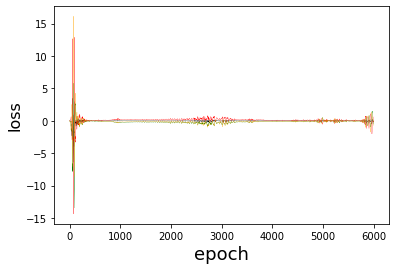

In [10]:
fig = plt.figure()
plt.plot([x[0] for x in wgan.d_losses], color="black", linewidth=0.25)
plt.plot([x[1] for x in wgan.d_losses], color="green", linewidth=0.25)
plt.plot([x[2] for x in wgan.d_losses], color="red", linewidth=0.25)
plt.plot(wgan.g_losses, color="orange", linewidth=0.25)

plt.xlabel("epoch", fontsize=18)
plt.ylabel("loss", fontsize=16)
plt.show()

## 生成图片及对比与生成图片相似的原始图片

In [11]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [12]:
r, c = 5, 5

idx = np.random.randint(0, x_train.shape[0], 32)
true_imgs = (x_train[idx] + 1) * 0.5

fig, axs = plt.subplots(r, c, figsize=(15, 15))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(true_imgs[cnt])
        axs[i, j].axis("off")
        cnt += 1
fig.savefig(os.path.join(RUN_FOLDER, "images/real.png"))
plt.close()

In [13]:
r, c = 5, 5
noise = np.random.normal(0, 1, (r * c, wgan.z_dim))
gen_imgs = wgan.generator.predict(noise)
gen_imgs = 0.5 * (gen_imgs + 1)

fig, axs = plt.subplots(r, c, figsize=(15, 15))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(np.squeeze(gen_imgs[cnt, :, :, :]))
        axs[i, j].axis("off")
        cnt += 1
fig.savefig(os.path.join(RUN_FOLDER, "images/sample.png"))
plt.close()

fig, axs = plt.subplots(r, c, figsize=(15, 15))
cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate((x_train + 1) * 0.5):
            diff = compare_images(gen_imgs[cnt, :, :, :], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img)
        axs[i, j].axis("off")
        cnt += 1
fig.savefig(os.path.join(RUN_FOLDER, "images/sample_closest.png"))
plt.close()